## Decision Tree and Ensemble extended project.
### Juan Felipe Godoy

This notebook presents the data work applied to the dataset of the MIMIC (Medical Information Mart for Intensive Care III) project. 

The main objective is to predict the length of stay ('LOS') in ICU for each patient applying Decision Trees and ensemble methods such as Random Forests, Gradient Boosting and Super lerners.

The structure of the notebook will be as follows:

    1.Initial setup
    2.Data exploration.
    3.Feature engineering
    4.Models
    5.Ensembles.


## 1. Intial Setup

### 1.1 Import packages and set working directory

In [86]:
# Import packages

%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import ipywidgets
from math import floor, ceil
import random
import time
import warnings

from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.pipeline import Pipeline

In [87]:
warnings.filterwarnings('ignore')

In [1]:
# Working directory: change here
#import os
#os.getcwd()

### 1.2 Utils and functions

In [3]:
# 1. Drops columns
def delete_columns(dataset, columns):
  dataset = dataset.drop(columns, axis=1)
  return dataset

#2. Calculates the age when entering ICU.
def age_admitted(data, columns):
  for c in columns:
    data[c] = pd.to_datetime(data[c])

  data['AGE'] = data['ADMITTIME'].dt.year - data['DOB'].dt.year

date_columns = ['DOB', 'ADMITTIME']

### 1.3 Load the data.

####  Training data

In [4]:
d_train = pd.read_csv("mimic_train.csv")
print(d_train.shape)
pd.set_option("display.max_columns", None)
d_train.head()

(20885, 41)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,F,2108-07-16 00:00:00,2178-02-06 10:35:00,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,F,2087-01-16 00:00:00,2129-02-12 22:34:00,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,88.0,72.888889,13.0,21.0,15.900000,36.444444,36.888889,36.666667,100.0,100.0,100.000000,132.0,346.0,217.636364,F,2057-09-17 00:00:00,2125-11-17 23:04:00,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,94.0,62.783784,12.0,35.0,26.771429,36.333333,39.500000,37.833333,78.0,100.0,95.085714,108.0,139.0,125.000000,F,2056-02-27 00:00:00,2131-01-26 08:00:00,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,137.0,113.000000,F,2066-12-19 00:00:00,2146-05-04 02:02:00,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


#### Test data

In [5]:
d_test = pd.read_csv("mimic_test_los.csv")
print(d_test.shape)


(5221, 39)


In [6]:
d_test.head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,64058,146725,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,77.0,52.018182,53.0,102.0,68.200000,6.0,24.0,12.294118,35.300000,38.200000,37.405149,95.0,100.0,99.191489,89.0,230.0,134.684211,M,2114-08-07 00:00:00,2196-02-23 11:45:00,-67454.42740,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,AORTIC STENOSIS\CORONARY ARTERY BYPASS GRAFT W...,4241,CSRU
1,55871,108789,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,86.0,65.578947,50.0,276.0,85.000000,20.0,40.0,26.097561,36.055556,39.444444,37.833333,93.0,100.0,97.666667,152.0,1016.0,391.526316,M,2055-06-04 00:00:00,2103-10-22 23:58:00,-34204.08546,EMERGENCY,Private,NOT SPECIFIED,MARRIED,WHITE,HYPERGLYCEMIA,25013,MICU
2,42892,139885,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,76.0,66.703704,60.0,87.0,77.346154,16.0,27.0,22.071429,37.166667,39.166667,38.380342,92.0,100.0,95.888889,100.0,149.0,123.000000,M,2073-04-21 00:00:00,2115-06-28 07:15:00,-38710.61714,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,KIDNEY STONES/SDA,5920,MICU
3,66629,173017,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,99.0,62.854545,46.0,110.0,78.500000,10.0,26.0,14.000000,35.944444,37.777778,36.928105,89.0,100.0,95.272727,130.0,177.0,147.250000,F,2078-04-14 00:00:00,2162-08-01 21:00:00,-54902.54313,EMERGENCY,Private,EPISCOPALIAN,WIDOWED,WHITE,RIGHT FEMUR FRACTURE,82120,CCU
4,79851,171573,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,133.0,72.833333,66.0,135.0,86.416667,7.0,29.0,24.161290,36.111111,37.277778,36.642857,86.0,100.0,96.000000,74.0,248.0,155.500000,F,2050-01-17 00:00:00,2103-01-16 22:05:00,-33906.93488,EMERGENCY,Medicare,CATHOLIC,SINGLE,WHITE,PNEUMONIA;RAPID AF;HYPOXIA,51884,MICU


## 2. Exploring the dataset

We can see that the dataset has missing values for an important number of variables. The figure below (msno.matrix) plots the missing values present in our dataset. We can see that there are some observations that don't have information for the vital sign group of variables. On the other hand, the categorical variables usually have information for the majority of the observations.  

Given that the predictions of the models are going to be affected by this issue, it is necessary to impute some information and replace the missing values. 
After exploring three methods from sklearn (Simple Imputer, Iterative Imputer and KnnImputer) the one that gave better scores was the SimpleImputer with the mean strategy. Therefore, all the pipelines used in this project are calibrated with this method. 

<AxesSubplot:>

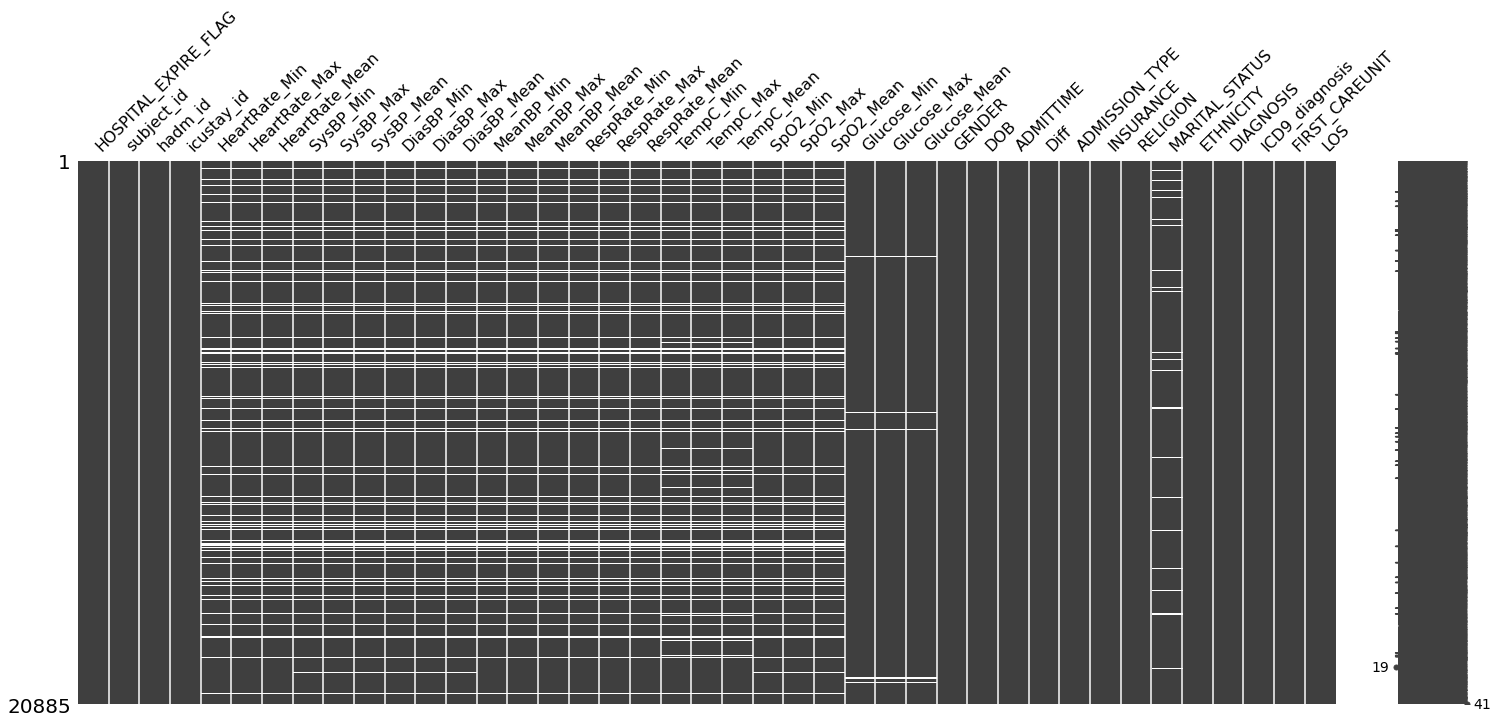

In [7]:
# Exploring missing values in the dataset.
import missingno as msno
## Matrix of missing data
msno.matrix(d_train)

In [8]:
# Investigate the type and null values of the data frame. 
print(d_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HOSPITAL_EXPIRE_FLAG  20885 non-null  int64  
 1   subject_id            20885 non-null  int64  
 2   hadm_id               20885 non-null  int64  
 3   icustay_id            20885 non-null  int64  
 4   HeartRate_Min         18698 non-null  float64
 5   HeartRate_Max         18698 non-null  float64
 6   HeartRate_Mean        18698 non-null  float64
 7   SysBP_Min             18677 non-null  float64
 8   SysBP_Max             18677 non-null  float64
 9   SysBP_Mean            18677 non-null  float64
 10  DiasBP_Min            18676 non-null  float64
 11  DiasBP_Max            18676 non-null  float64
 12  DiasBP_Mean           18676 non-null  float64
 13  MeanBP_Min            18699 non-null  float64
 14  MeanBP_Max            18699 non-null  float64
 15  MeanBP_Mean        

Another important question to ask is how correlated are the variables in the dataset. If most of them are strongly correlated one could use some techniques of feature selection to reduce the number of columns. Examples of tools are principal component analysis or factor analysis.

Given that in this project the models (Decision Trees, Random Forest, Gradient Boosting and XGBosst) already deal with feature selection, it won't be necessary to implement other techniques. Nevertheless, it is always useful to plot a correlation matrix to understand the relations between the features. Particularly those that can give clues about the variable of interest (LOS).


In [9]:
# Correlation heatmap with pandas dataframes
corr = d_train.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,LOS
HOSPITAL_EXPIRE_FLAG,1.000000,-0.008040,0.001671,-0.010380,0.006973,0.129469,0.110773,-0.194698,-0.028490,-0.128680,-0.138257,-0.022246,-0.099773,-0.176074,0.014403,-0.113767,0.072560,0.135877,0.175122,-0.136591,-0.042721,-0.110223,-0.234060,-0.049621,-0.156872,0.064290,0.084702,0.105205,-0.000994,0.129171
subject_id,-0.008040,1.000000,0.001632,0.009190,-0.014465,0.012753,0.005136,0.004272,-0.001984,0.001163,0.024030,-0.008767,0.004136,0.007592,0.002562,0.014765,-0.011453,-0.004550,-0.013314,0.028944,0.028286,0.041709,0.031310,0.010123,0.022002,-0.014887,-0.005925,-0.014528,0.029185,-0.003278
hadm_id,0.001671,0.001632,1.000000,0.001267,-0.000180,-0.001161,-0.003855,0.004644,0.003162,-0.000656,-0.006482,0.001432,-0.007318,0.006186,-0.000818,-0.005452,0.003258,0.007753,0.007233,0.014773,0.005036,0.010348,0.002342,-0.000796,0.004578,0.010261,0.001627,0.006684,-0.005631,0.005752
icustay_id,-0.010380,0.009190,0.001267,1.000000,-0.012199,-0.010824,-0.011717,0.008117,-0.004977,0.001652,-0.002750,-0.000246,-0.006574,0.002487,-0.009237,-0.002950,-0.010060,-0.019477,-0.018287,-0.004161,-0.004104,-0.007023,0.007117,0.002103,0.006855,0.007902,0.003823,0.008410,-0.002418,-0.007068
HeartRate_Min,0.006973,-0.014465,-0.000180,-0.012199,1.000000,0.534691,0.835975,0.038665,-0.102884,-0.052779,0.168651,0.055306,0.189643,0.111489,-0.007760,0.097949,0.212562,0.219848,0.278638,0.172000,0.205834,0.231930,0.037288,-0.053644,-0.026538,0.028392,0.033732,0.039477,-0.003790,0.079271
HeartRate_Max,0.129469,0.012753,-0.001161,-0.010824,0.534691,1.000000,0.815396,-0.148021,0.044394,-0.077772,0.043673,0.181351,0.176346,-0.047747,0.117893,0.094867,0.117835,0.331484,0.295923,0.065504,0.281315,0.212692,-0.130294,0.020788,-0.057684,0.023852,0.065252,0.063135,-0.003423,0.150670
HeartRate_Mean,0.110773,0.005136,-0.003855,-0.011717,0.835975,0.815396,1.000000,-0.086398,-0.041675,-0.088590,0.109793,0.126144,0.206236,0.019877,0.063943,0.105651,0.182360,0.325395,0.344531,0.120398,0.277931,0.252202,-0.095199,-0.026342,-0.082433,0.033418,0.066062,0.069151,-0.000914,0.116884
SysBP_Min,-0.194698,0.004272,0.004644,0.008117,0.038665,-0.148021,-0.086398,1.000000,0.337775,0.746303,0.582369,0.176277,0.490863,0.675652,0.081787,0.608390,0.077212,-0.134374,-0.076149,0.172874,-0.023904,0.087055,0.208785,-0.066891,0.048382,0.093313,-0.030690,0.015540,-0.003274,-0.132064
SysBP_Max,-0.028490,-0.001984,0.003162,-0.004977,-0.102884,0.044394,-0.041675,0.337775,1.000000,0.750204,0.153762,0.530351,0.362954,0.206148,0.481129,0.576402,-0.048962,0.038554,-0.018351,0.026923,0.109619,0.097842,-0.012536,0.051815,0.043272,0.043844,0.094198,0.101067,-0.018405,0.068940
SysBP_Mean,-0.128680,0.001163,-0.000656,0.001652,-0.052779,-0.077772,-0.088590,0.746303,0.750204,1.000000,0.425213,0.396742,0.550498,0.512128,0.314230,0.776103,0.024136,-0.064519,-0.054167,0.121203,0.038127,0.105064,0.113261,-0.006948,0.054006,0.096136,0.052830,0.088808,-0.019034,-0.048819


From the table above we see that in general the vital sign features are strongly correlated with each other, suggesting that for some models it could be useful to aggregate them or apply any dimensionality reduction method. The SysBP_ family positively correlates with the DiasBP_ and MeanBP_ family.

##  3. Feature Engineering

Sometimes, the variables included in the original data set don't have a strong prediction power and it is worth creating new ones or transforming them from existing information. For example, the table above shows that none of the existing variables have a strong correlation with the length of stay. Therefore, in this case we will create three new features that could help in our prediction exercise.

The additional feature engineering such as scaling or imputing missing values will be included further below in the pipelines of each models. 

To start with I will drop the HOSPITAL_EXPIRE_FLAG feature, given that for this exercise it would be unknown information at the time of entrance to ICU.

In [10]:
# Drop prohibited variables 
d_train = d_train.drop('HOSPITAL_EXPIRE_FLAG',1)

### 3.1 Number of entries

From the previous exercise we learned that the number of entries to ICU had an impact on the probability of death. Therefore, it is natural to ask ourselves if it is also the case with the length of stay ('LOS').

In [11]:
## Number of entrances per patient.
indicators_train = d_train[['subject_id', 'hadm_id', 'icustay_id']]
indicators_test = d_test[['subject_id', 'hadm_id', 'icustay_id']]

# Append both data sets
total_indicators = pd.concat([indicators_train, indicators_test], axis = 0)
d_entrnc_ICU = total_indicators.groupby(['subject_id'])['icustay_id'].nunique().reset_index()
d_entrnc_ICU.rename(columns={'icustay_id': 'num_entrances'}, inplace=True)


In [12]:
# Merge with d_train
d_train = pd.merge(d_train, d_entrnc_ICU, on=['subject_id'])
d_train.head()
print(d_train.shape)

# Merge  with d_test 
d_test = d_test.merge(d_entrnc_ICU, on='subject_id', how='left')
d_test.head()
print(d_test.shape)

(20885, 41)
(5221, 40)


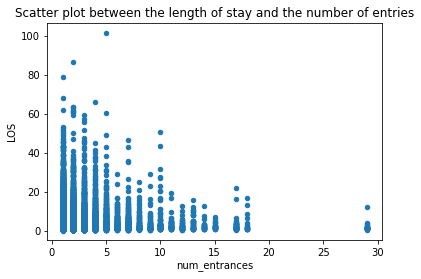

In [16]:
import matplotlib.pyplot as plot
d_train.plot.scatter(x='num_entrances', y='LOS', title= "Scatter plot between the length of stay and the number of entries");

plot.show(block=True);

From the graph above we can see that there is a negative correlation between the number of entrances and the length of stay. Apparently, patients with many entrances stay less than those with only one visit.

### 3.2 Total number of comorbidities

Another interesting factor that could affect the length of stay is related to the comorbidities each patient had during the stay at the ICU. Probably, patients with more comorbidities require special assistance therefore, increasing the length of stay. 
In contrast to the last project, here we will count the number of comorbidities each patient had when entering the hospital.

In [17]:
# Import data set
d_comob = pd.read_csv("extra_data/MIMIC_diagnoses.csv")

pd.set_option("display.max_columns", None)
d_comob.rename(columns={'SUBJECT_ID': 'subject_id', 'ICD9_CODE': 'ICD9_diagnosis', 'HADM_ID':'hadm_id'}, inplace=True)

# Number fo comorbidities per entrance
d_comob = d_comob.groupby(['subject_id','hadm_id'])['ICD9_diagnosis'].nunique().reset_index()
d_comob.rename(columns={'ICD9_diagnosis': 'number_comorbidites'}, inplace=True)


In [18]:
d_comob.head(20)

,subject_id,hadm_id,number_comorbidites
0,2,163353,3
1,3,145834,9
2,4,185777,9
3,5,178980,3
4,6,107064,8
5,7,118037,3
6,8,159514,6
7,9,150750,6
8,10,184167,5
9,11,194540,1


In [19]:
# Merge with d_train
d_train = pd.merge(d_train, d_comob, on=['subject_id', 'hadm_id'], how = 'left')
d_train.head()
print(d_train.shape)

# Merge  with d_test 
d_test = d_test.merge(d_comob, on=['subject_id', 'hadm_id'], how='left')
d_test.head()
print(d_test.shape)

(20885, 42)
(5221, 41)


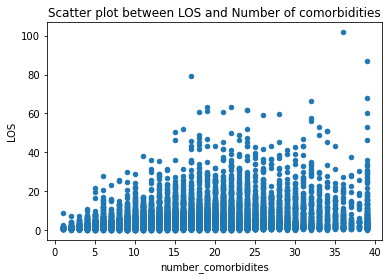

In [21]:
d_train.plot.scatter(x='number_comorbidites', y='LOS', title= "Scatter plot between LOS and Number of comorbidities");

plot.show(block=True);

When we plot the number of comorbidities against the length of stay, we see that there is a positive correlation between both of them.

### 3.3 Age when admitted

In third place, I will consider the age when admitted to see if it is a good predictor of the length of stay. However, this time instead of dropping the outliers present in the variable, I will impute NaN values to observations with ages greater than 100 years. The idea is that they will be replaced in the PipeLine using SimpleImputer. Thus, I won't lose information and can train the models with more observations.

In [26]:
#Calculate the age of the patient at the moment of the admission to the ICU
age_admitted(d_train, date_columns)
age_admitted(d_test, date_columns)

<AxesSubplot:>

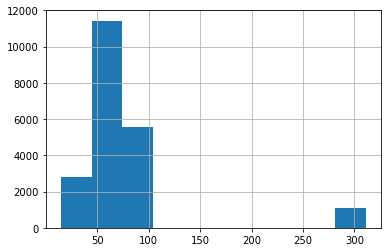

In [27]:
# Run again the histogram.
d_train['AGE'].hist()

In [28]:
# Truncating the age variable to 90 for ages greater tha 100 (d_test) and replacing with nan (d_train)
d_train.loc[d_train['AGE'] > 100, 'AGE'] = 101
d_train['AGE'].replace(101, np.NaN)

# Test
d_test.loc[d_test['AGE'] > 100, 'AGE'] = 101


<AxesSubplot:>

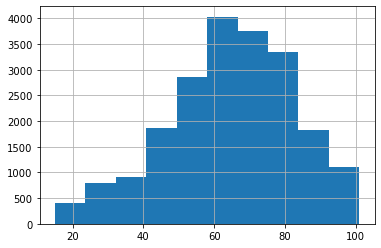

In [29]:
# Run again the histogram.
d_train['AGE'].hist()

### 3.4 List of variables

Finally, I will create a list of variables which I'll use in the PipeLine. 

In [31]:
# Obtain numerical variables
numerical_var = ['HeartRate_Min','HeartRate_Max','HeartRate_Mean','SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 
       'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 
       'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'number_comorbidites', 'num_entrances','AGE']


In [32]:
# Obtain categorical variables
categorical_variables = ['ADMISSION_TYPE', 'FIRST_CAREUNIT', 'INSURANCE',
                'GENDER']

In [33]:
# Obtain useless variables
useless_var = ['subject_id','hadm_id', 'icustay_id', 'MARITAL_STATUS', "Diff", "DOB", "ADMITTIME", 'ICD9_diagnosis', 'DIAGNOSIS', 'ETHNICITY', 'RELIGION', 'LOS']
useless_var_test = ['subject_id','hadm_id', 'icustay_id', 'MARITAL_STATUS', "Diff", "DOB", "ADMITTIME", 'ICD9_diagnosis', 'DIAGNOSIS', 'ETHNICITY', 'RELIGION']

In [34]:
# X_train
X_train=d_train
X_test=d_test

In [35]:
### Y train
y_train = d_train[['LOS']]

In [36]:
X_train = delete_columns(X_train, useless_var)
X_test = delete_columns(X_test,useless_var_test)

### 4. Trees, Forest, Boosting  and PipeLine 

In this section I will run four models: Decision Tree, Random Forest, Stochastic Gradient Boosting and XGBoost. 
Each of the parameters are tuned using a grid search with a PipeLine and the best model is selected to make the predictions.  

#### 4.1 The PipeLine

To begging with it is worth explaining the structure of the PipeLine used in the following models. 

   Step 1-Numeric Transformer-. First of all I define an object containing the transformer of the numeric variables. As mentioned before I will apply a SimpleImputer to deal with NaN and a StandardScaler to scale the data when needed. Other Imputers where considered (IterativeImputer ans KnnImputer), but I obtained the best results with the StandardScaler)
    
   Step 2-preprocessor-. Secondly, I set the Columntransformer with the object built in the first step and I include a OneHoteEncoder to convert the categorical variables. 
   
   Step 3. I setup the Pipeline by including the objects created in step 1 and step 2.
   
   Step 4. For each of the models create a dictionary of list with all the needed parameters in the PipeLine. This usually has the parameters for the functions from object in step 1 and the parameters of the weak learner (DT, RF, SGB and XGB)


##### Note: 
The values of the parameters displayed in the cells are the ones that yield better scores. I ran many grid searches but for this clean notebook I am reporting only the ones that yield the final results. In some cases, I commented the list of parameters to prove the range of experimentation.

#### 4.1 Decision Tree

Decision Trees belong to the family of non-parametric supervised learning models. They follow simple decision rules inferred from the data features. 

Some of their advantages are that they require little data preparation. As we discuss before, in principle they can run despite of the missing values or lack of normalization. They can handle both numerical and categorical data and one can validate their results with using statistical tests.

However, if the maximum depth is not well selected they can cause problems of overfitting. Additionally, their results are unstable in the sense that small changes in the data can yield different results. 

In this exercise we will present the results of the decision tree below. Some of the parameters considered are commented in the 'param_grid' dictionary.

In [39]:
# Import packages
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as MSE

In [40]:
#Transformers setup
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

In [41]:
#setup the column transformer for preprocessing step in the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numerical_var),
        ('categorical', OneHotEncoder(), categorical_variables)
    ])

In [42]:
#Setup the pipeline steps
gs = Pipeline(steps=[
                    ('preprocessing',preprocessor ),
                    ('regressions', DecisionTreeRegressor())])

#Set parameters and prepare grid search
param_grid = {
    'preprocessing__numerical__imputer__strategy':['mean'],
    'regressions__criterion':['mse'], # only available in the version of anaconda I managed to install
    'regressions__max_features':[5,10,20],
    'regressions__max_depth':[2,3,4],
    'regressions__random_state':[123]
}

# First param_grid
#param_grid = {
    #'preprocessing__numerical__imputer__max_iter':[10,30,50],
    #'preprocessing__numerical__imputer__strategy':['mean', 'median'],
    #'regressions__criterion':['mse'],
    #'regressions__max_features':[5,10,20,30,40],
    #'regressions__max_depth':[2,3,4,5,6],
    #'regressions__random_state':[123]
#}


In [43]:
## Grid Search
from sklearn.model_selection import GridSearchCV

dt_gs = GridSearchCV(gs, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=2)

In [44]:
## Fit the model
dt_gs.fit(X_train, y_train);

In [50]:
# Summary results
dt_df=pd.DataFrame(dt_gs.cv_results_)

dt_df_s =dt_df[['param_regressions__max_depth', 
                'param_regressions__max_features', 
                'mean_test_score', 
                'rank_test_score']]
dt_df_s


,param_regressions__max_depth,param_regressions__max_features,mean_test_score,rank_test_score
0,2,5,-5.094127,9
1,2,10,-5.013571,7
2,2,20,-4.893576,2
3,3,5,-5.073530,8
4,3,10,-4.967059,5
5,3,20,-4.851621,1
6,4,5,-5.005998,6
7,4,10,-4.931952,4
8,4,20,-4.908113,3


In [47]:
dt_gs.best_score_

-4.851620821239294

In [389]:
# Prediction
y_predict= dt_gs.predict(X_test)

In [390]:
y_predict

array([5.61848177, 2.6332159 , 2.6332159 , ..., 1.80480673, 2.74028108,
       2.6332159 ])

After running the gridsearch the best decision tree yield a mean_test_score of -4.851 with a maximum depth of 3 and a selection of maximum features of 20.

#### 4.2.Random Forest

In principle, random forest is an ensemble method that uses decision tree as a base estimator. Each estimator is trained on a different bootstrap sample having the same size as the training set. After each tree is trained, only d features are sampled at each node without replacement. In scikit-learn the default for d is the square root of the number of features.

It is an ensemble method because when new instances are passed to the base estimators, each of them outputs a prediction. All of them are collected by the R.F. (meta classifier) and a new prediction is made. 

We will see how the predictions improve with this ensemble method.

In [51]:
from sklearn.ensemble import RandomForestRegressor

Given that the base estimator of the R.F. is a decision tree, it is not necessary to change steps 1 and 2 of the Pipeline. 

In [52]:
#Setup the pipeline steps
gs = Pipeline(steps=[
                    ('preprocessing',preprocessor ),
                    ('regressions', RandomForestRegressor())])

#Set parameters and prepare grid search
param_grid = {
    #'preprocessing__numerical__imputer__max_iter':[10,30,50],
    'preprocessing__numerical__imputer__strategy':['mean'],
    #'regressions__criterion':['entropy', 'gini'],
    'regressions__n_estimators':[100, 150,],
    'regressions__max_features':[5,10,20],
    'regressions__max_depth':[2,3,4],
    'regressions__random_state':[123]
}

In [53]:
# GridSearch
rf_gs = GridSearchCV(gs, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=2)

In [88]:
rf_gs.fit(X_train, y_train);

In [60]:
# Summary results
rf_df=pd.DataFrame(dt_gs.cv_results_)

rf_df_s =rf_df[['param_regressions__max_depth', 
                'param_regressions__max_features', 
                'mean_test_score', 
                'rank_test_score']]
#rf_df_s

In [58]:
rf_gs.best_score_

-4.78820320643235

In [397]:
y_predict= rf_gs.predict(X_test)

In [398]:
y_predict

array([5.35274081, 4.00565983, 3.40674239, ..., 1.92718202, 2.51319413,
       2.67023672])

We see that with this ensemble method we obtain a slightly better score. 

#### 4.3. Boosting

Boosting is an ensemble method in which many predictors are trained and each precitor learns from the errors of its predecessor.

####  Stochastiing Gradient boosting

One drawback of Gradient boosting is that it involves an exhaustive search procedure. Each tree in the ensemble is trained to find the best split points and the best features. The consequence of this is that it may lead to CART that use the same split point and same features. 

To deal with this, one can use the stochastic gradient boosting. In this ensemble method, each CART is trained on a random subset of the training data and the subset is sampled without replacement.

Additionally, at each node, the features are sample also without replacement when choosing the split points, resulting in further diversity in the ensemble and adding more variance to the trees.


In [61]:
from sklearn.ensemble import GradientBoostingRegressor

In [65]:
#Setup the pipeline steps
gs = Pipeline(steps=[
                    ('preprocessing',preprocessor ),
                    ('regressions', GradientBoostingRegressor())])

#Set parameters and prepare grid search
param_grid = {
    #'preprocessing__numerical__imputer__max_iter':[10,30,50],
    'preprocessing__numerical__imputer__strategy':['mean'],
    'regressions__criterion':['mse'],
    #'regressions__base_estimator':['dt']
    'regressions__n_estimators':[50,100, 150,200],
    #'regressions__max_features':[5,10,20],
    'regressions__loss':['ls','lad'],
    'regressions__subsample':[0.8,0.85,0.87],
    #'regressions__max_depth':[2,3,4],
    'regressions__random_state':[123]
}

In [66]:
# GridSearch
sgb_gs = GridSearchCV(gs, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=2)

In [100]:
sgb_gs.fit(X_train, y_train);

In [69]:
sgb_df=pd.DataFrame(sgb_gs.cv_results_)
#gb_df

In [70]:
sgb_gs.best_score_

-4.683135855690492

In [71]:
y_predict= sgb_gs.predict(X_test)
y_predict

array([6.03979854, 4.97952603, 3.25423737, ..., 0.94840603, 2.1577298 ,
       1.50684548])

Using stochastic gradient boosting the score improves even more.

####  XGBoost

Finally, the last model included in this notebook is the XGBoost also from the family of gradient boosting. XGboost is design to be both computationally efficient and highly effective. It has become popular for wining several kaggle competitions both for classification  and regression problems. 

In [141]:
#conda install xgboost

In [408]:
import xgboost
from xgboost import XGBRegressor

In [409]:
#Setup the pipeline steps
gs = Pipeline(steps=[
                    ('preprocessing',preprocessor ),
                    ('regressions', XGBRegressor())])

#Set parameters and prepare grid search
param_grid = {
    #'preprocessing__numerical__imputer__max_iter':[10,30,50],
    'preprocessing__numerical__imputer__strategy':['mean'],
    #'regressions__criterion':['mse'],
    #'regressions__base_estimator':['dt']
    'regressions__n_estimators':[50,100, 150,200],
    #'regressions__max_features':[5,10,20],
    #'regressions__loss':['ls','lad'],
    'regressions__eta':[0.1,0.2],
    'regressions__subsample':[0.8,0.85],
    'regressions__max_depth':[4,5,6],
    'regressions__random_state':[123]
}

In [410]:
xgb_gs = GridSearchCV(gs, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=2)

In [411]:
xgb_gs.fit(X_train, y_train);

In [412]:
xgb_df=pd.DataFrame(xgb_gs.cv_results_)
xgb_df.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__numerical__imputer__strategy,param_regressions__eta,param_regressions__max_depth,param_regressions__n_estimators,param_regressions__random_state,param_regressions__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.427780,0.088484,0.024534,0.000798,mean,0.1,4,50,123,0.8,{'preprocessing__numerical__imputer__strategy'...,-4.995058,-4.907501,-4.583598,-4.401531,-4.506047,-4.678747,0.231563,3
1,1.352375,0.009526,0.024136,0.000399,mean,0.1,4,50,123,0.85,{'preprocessing__numerical__imputer__strategy'...,-4.996503,-4.919785,-4.609562,-4.397635,-4.517660,-4.688229,0.231680,10
2,2.587095,0.007316,0.026914,0.000885,mean,0.1,4,100,123,0.8,{'preprocessing__numerical__imputer__strategy'...,-5.001663,-4.885422,-4.559584,-4.402944,-4.502492,-4.670421,0.231506,1
3,2.663077,0.099660,0.026330,0.001017,mean,0.1,4,100,123,0.85,{'preprocessing__numerical__imputer__strategy'...,-5.003624,-4.887628,-4.599087,-4.391411,-4.514444,-4.679239,0.230251,4
4,3.833358,0.020981,0.029510,0.002799,mean,0.1,4,150,123,0.8,{'preprocessing__numerical__imputer__strategy'...,-5.018559,-4.885446,-4.561611,-4.403075,-4.513568,-4.676452,0.234593,2


In [413]:
xgb_gs.best_score_

-4.670420868591245

In [414]:
y_predict= xgb_gs.predict(X_test)
y_predict

array([5.406662 , 4.265157 , 2.9175787, ..., 1.2570689, 2.0000858,
       1.2334121], dtype=float32)

As expected the score optained using XGBoost was the best of the four models. 

### 5. Ensemble

So far, we have worked with ensemble methods that work really good with decision trees as weak learners. However, there are other methods that allow us to combine different weak learners outside decision trees. In this section I will explore two of them: the SuperLearner and the SeqeuntialEnsemble.

For each of the weak learners applied in the ensemble methods I will introduce the parameters obtained from the results above. for example, for the D.T. the maximum depth will take the value of three and the max number of features will be 20. Weak learners for which I don't have parameters, will run with the default values from sklearn. 

In [89]:
# Import modules
from sklearn.metrics import accuracy_score
from mlens.ensemble import SuperLearner
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

The Super Learner is a supervised ensemble algorithm that uses k-fold estimation to map a training set into a prediction by stacking the results of other weak learners trained on the same split of the data. All out of fold predictions are used to train an algorithm that learns how to best combine the predictors. 

In the example below I will train a Super Learner suing Decision Tree regressor and SVR as weak learners and Random Forest regressor as meta learner.

In [81]:
#Super Learner
ensemble = SuperLearner(scorer=accuracy_score, random_state=123)

# First Layer
ensemble.add([DecisionTreeRegressor(max_depth=3,max_features=20,random_state=123),SVR()])

# Second Layer
ensemble.add([SVR(),RandomForestRegressor()])

# Third Layer
#ensemble.add([KNeighborsClassifier(), GradientBoostingRegression()])

# Meta estimator
ensemble.add_meta(RandomForestRegressor())

SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=3582, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...34D3280>)],
   n_jobs=-1, name='group-6', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=123, sample_size=20,
       scorer=<function accuracy_score at 0x00000247B34D3280>,
       shuffle=False, verbose=False)

In [82]:
gs = Pipeline(steps=[
                    ('preprocessing',preprocessor ),
                    ('regressions', ensemble)])

#Set parameters and prepare grid search
param_grid = {
    'preprocessing__numerical__imputer__strategy':['mean']

}

In [83]:
ens_gs = GridSearchCV(gs, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=2)

In [99]:
ens_gs.fit(X_train, y_train);

In [85]:
ens_df=pd.DataFrame(ens_gs.cv_results_)
ens_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__numerical__imputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,157.548147,27.754835,41.353449,5.721992,mean,{'preprocessing__numerical__imputer__strategy'...,-5.215502,-5.324091,-4.901048,-4.80788,-4.926333,-5.034971,0.198741,1


#### Sequential Learner

This ensemble allows users to build ensembles with different classes of layers, similar to the previous ensemble Super Learner.

In [90]:
from mlens.ensemble import SequentialEnsemble

In [94]:
#Sequential

ensemble_s = SequentialEnsemble(random_state=123, verbose=2)

# First Layer
#ensemble_s.add('blend',list([DecisionTreeRegressor(random_state=123)]))
ensemble_s.add('stack',list([DecisionTreeRegressor(max_depth=3,max_features=20,random_state=123)]))

# Second Layer
ensemble_s.add('blend',[KNeighborsRegressor(),SVR()])


# Meta estimator
ensemble_s.add_meta(RandomForestRegressor())

SequentialEnsemble(array_check=None, backend=None,
          layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=3582, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...er=None)],
   n_jobs=-1, name='group-12', raise_on_exception=True, transformers=[])],
   verbose=1)],
          model_selection=False, n_jobs=None, raise_on_exception=True,
          random_state=123, sample_size=20, scorer=None, shuffle=False,
          verbose=2)

In [95]:
gs = Pipeline(steps=[
                    ('preprocessing',preprocessor ),
                    ('regressions', ensemble_s)])

#Set parameters and prepare grid search
param_grid = {
    'preprocessing__numerical__imputer__strategy':['mean']

}

In [96]:
ens_seq_gs = GridSearchCV(gs, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=2)

In [97]:
ens_seq_gs.fit(X_train, y_train);


Fitting 3 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:59
Processing layer-3             done | 00:00:00
Fit complete                        | 00:01:00


In [98]:
ens_seq_df=pd.DataFrame(ens_seq_gs.cv_results_)
ens_seq_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__numerical__imputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,47.401834,3.96772,19.342681,2.624266,mean,{'preprocessing__numerical__imputer__strategy'...,-5.096323,-5.24415,-4.845494,-4.755833,-4.788916,-4.946143,0.191014,1


We see that applying both ensemble methods we obtain one parameter with a score at least as good as the one obtained by the individual weak learner. 

In [ ]:
# Export to Kaggel
data_test = pd.read_csv('mimic_test_los.csv')
prediction = pd.DataFrame()
prediction['icustay_id'] = data_test['icustay_id']
prediction['LOS']= y_predict

#prediction['LOS_precit']= [x[1] for x in y_predict]
prediction.to_csv('pred_JuanF_Godoy_1.csv', index=False)
print(prediction)